# Lecture 8: Normalizing Flows

In this notebook, you'll find various tasks encompassing both theoretical and coding exercises. Each exercise corresponds to a specific number of points, which are explicitly indicated within the task description.

Always use the Jupyter kernel associated with the dedicated environment when compiling the notebook and completing your exercises.

#### **Attention** This sheet contains 10 bonus points (bonus task 2). Furthermore, if you present your own solution to either excercises 1 (theory) or 1, 2 (programming) in the tutorials, you are entitled for 10 additional bonus points.

## Excercise 1 (Theory) (30/100)

### Training NICE vs RealNVP

In the litterature of coupling-based normalizing flows two popular choices are [NICE](https://arxiv.org/abs/1410.8516) and [RealNVP](https://arxiv.org/abs/1605.08803). These are so called coupling-based normalizing flows since the overall model is composition of multiple transformation, i.e., coupling blocks, stack together. The two transformations for the two algorithms read
$$
\textrm{NICE} \implies
\begin{align*}
\begin{align*}
x_{1:d}' &= x_{1:d} \\
x_{(d+1):D}' &= x_{(d+1):D} + m_\theta(x_{1:d})
\end{align*}

\,\,\,\,\,\,\,\, && \,\,\,\,\,\,\,\, \textrm{RealNVP} \implies

\begin{align*}
x_{1:d}' &= x_{1:d} \\
x_{(d+1):D}' &= x_{(d+1):D} \odot \exp(s_\phi(x_{1:d})) + m_\theta(x_{1:d})
\end{align*}
\end{align*}
$$
About the notation:
> - $m_\theta$ and $s_\phi$ are two neural networks parametrized by a set of parameters $\theta$ and $\phi$ respectively.
> - The subscript in, e.g., $x_{1:d}$ refers to all elements of a D-dimensional tensor $x$ from $1$ to $d$. 
> - The superscript $'$ refers to the transformed variables while the variables **without** the superscript $'$ refer to the original input tensors. 
> - The $\odot$ refers to the tensor product (for the generalized case of high dimensional tensors). In can be understood as a generalization of the product operation. 


- **Task (1.a)** **(5.pts)** Write down the Jacobian of the transformation for both coupling transformations. 
- **Task (1.b)** **(15.pts)** Show that both type of coupling transformations fulfill the requirements of normalizing flows. 
- **Task (1.c)** **(10.pts)** RealNVP stays for *Real Non-Volume Preserving*. From your results derived above, can you explain why is RealNVP non-volumen preserving? Is this different compared to the NICE coupling transform? 


> Your Solution here. 

## Excercise 1 (Programming) (50/100)

[Normalizing flows](https://paperswithcode.com/method/normalizing-flows#:~:text=Normalizing%20Flows%20are%20a%20method,the%20sequence%20of%20invertible%20mappings.) are powerful tools which allow you to model and learn probability densities. Those models are often trained by minimizing the so-called [Reverse KL divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) as an objective. The **Reverse** KL divergence is another metric defined between two probability distributions and reads:
$$
\textrm{KL}(q_\theta\vert\vert p) = \int q_\theta(x)\ln\frac{q_\theta(x)}{p}\textrm{d}x\,.
$$ 
You've learned about the **reverse KL divergence** and **normalizing flows** in the lecture.        

This excercise will help you to start getting familiar with the idea of learning probability densities using variational inference.     
The first cell installs some packages you'll need, the second cell defines the base distribution and build the normalizing flow model `nfm`, the third cell plots the base and the target densities. 
In the following excercise, you are given two tasks described in the cells below.      


> Hint: In the following excercise you'll be using a package for the quick implementation of normalizing flows called `nflows`. If you want to know more or browse some of the functions you could use from this package, you can refer to [the GitHub page of the project](https://github.com/VincentStimper/normalizing-flows).


In [1]:
#Let's install some packages first

# import sys
# !{sys.executable} -m pip install normflows
# !{sys.executable} -m pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87246 sha256=81654985c2625b1bdfe106ccaa9f1cb931f6ec860c30bb1fb1fb37a8251c14ed
  Stored in directory: /Users/kimnicoli/Library/Caches/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import normflows as nf 

grid_size = 1000

n_couplings = 16
cmap = plt.get_cmap('PiYG')

flows = []
for i in range(n_couplings):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoMoons()

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

/home/benedikt/anaconda3/envs/ML_env/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1715567101190/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


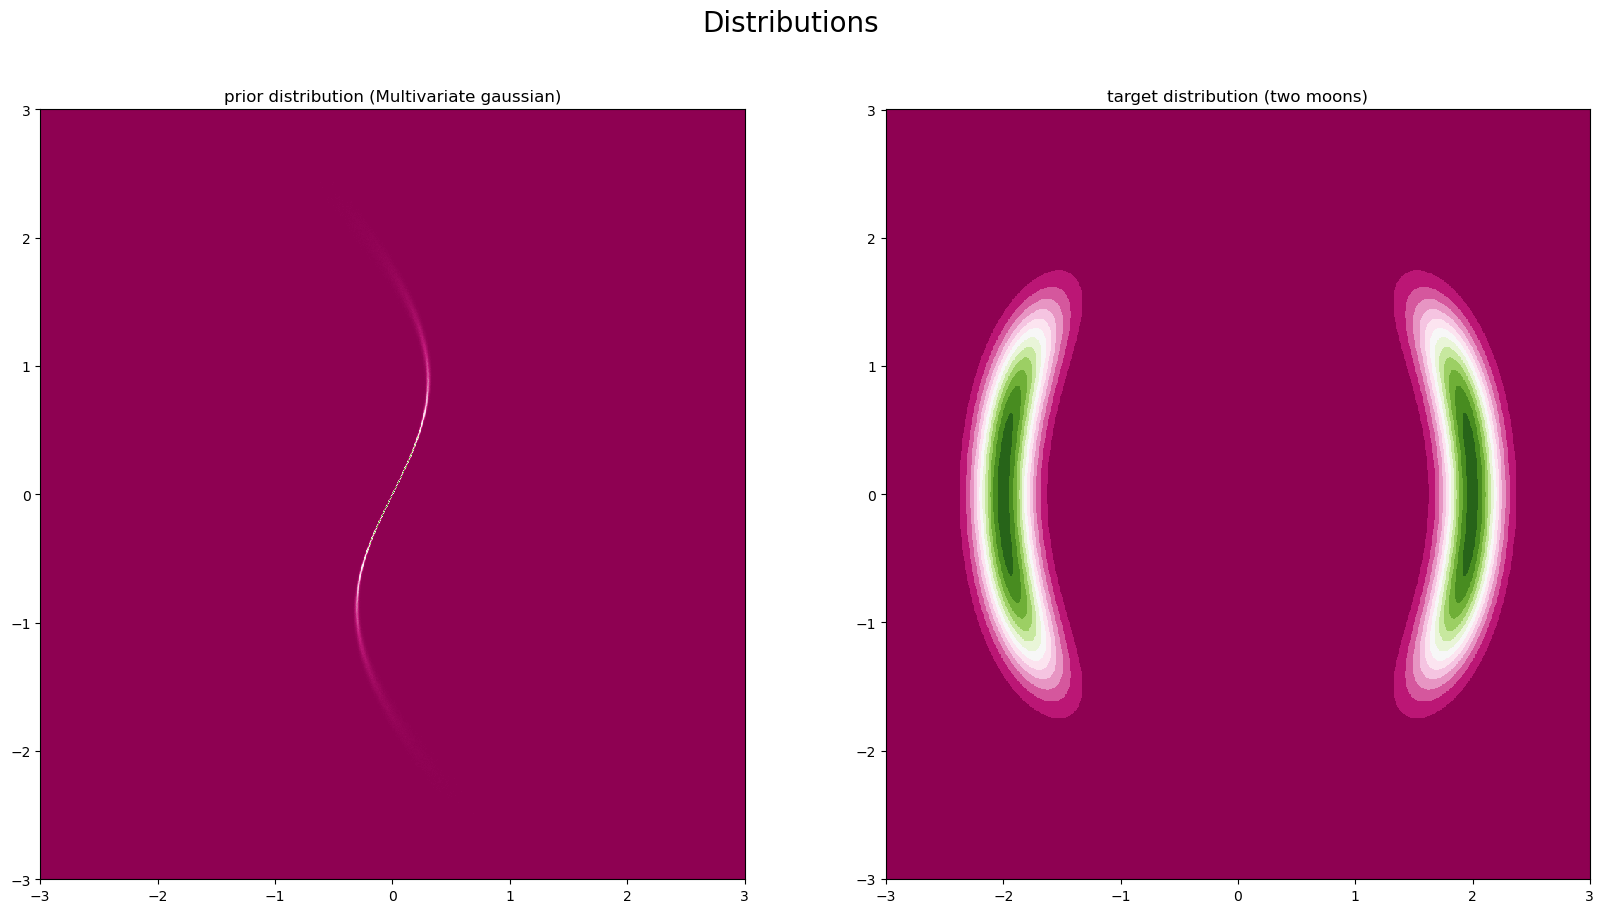

In [2]:
# Plot initial flow distribution

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
ax1.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]], cmap=cmap)

xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

# Convert tensors to numpy arrays
levels = MaxNLocator(nbins=15).tick_values(prob.min(), prob.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

ax2.pcolormesh(xx.numpy(), yy.numpy(), prob.numpy(), cmap=cmap, norm=norm)

ax1.set_title("prior distribution (Multivariate gaussian)")
ax2.set_title("target distribution (two moons)")
plt.suptitle("Distributions", fontsize=20)
plt.show()

**Task 1.a (40 pts.)** Implement the reverse KL divergence loss
$$
\textrm{KL}(q_\theta \vert\vert p ) = \int \textrm{d}(x)\,\, q_\theta(x) \ln\frac{q_\theta(x)}{p(x)}
$$
where $q_\theta$ and $p$ represent your learned and target densities respectively. Remember that you can access the log probability of the target distribution by doing `target.log_prob`

> #### Hint: if you have more than one coupling block in the flow, i.e., `n_couplings` > 1 you should make sure to iterate through all the blocks and their coupling layers and accumulate the log determinant.

In [ ]:
def your_reverse_kld(prior, target, flows, num_samples=1):
    # ----------------------------------
    #  Your code here
    # ----------------------------------
    pass

**(Task 1.b)**
- **(5 pts.)** Train the model and plot the learned density every $n$ steps, i.e., you can sample from the model at different steps during training to appreciate how the training goes. 
- **(5 pts.)** What is the final value for the loss you reach? Is that what you would expect?  

In [ ]:
# Train model
# N.B. flows represents the list of transformations combined together. 

max_iter = 20000
n_samples = 2 * 20
show_iter = 1000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-4)

for iter in tqdm(range(max_iter)):
    optimizer.zero_grad()

    loss = your_reverse_kld(q0, target, flows, n_samples)
    
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution during training. You can re-use the functions used to plot the prior and target distributions above

    if (iter + 1) % show_iter == 0:
        # ----------------------------------
        #  Your code here
        # ----------------------------------

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Excercise 2 (Programming) (20 + 10 bonus/100)

### Alternating Checkerboard partitioning

Coupling based normalizing flows require to split the original input into two partitions $(A,B)$ which are transformed by constraining the output of one partition A onto the input of the other partition B, which is instead transformed as the identity. If the normalizing flow has more than one coupling block, the role of partitions A and B is alternated in between coupling layers. An example of such transformation on partitions is the following
$$
\textrm{CustomTransform} \implies

\begin{align*}
\boldsymbol{x}_{A}' &= \boldsymbol{x}_{A} \\
\boldsymbol{x}_{B}' &= \boldsymbol{x}_{B} + \vert\vert \boldsymbol{x}_{A} \vert\vert_2
\end{align*}
$$
where the $'$ refers to the updated output. The output of the `CustomTransform` merges back the updated partitions into $(A',B')$ which is then passed as input to the next coupling block and so on.

- **Task 2.a (20 pts.)** Your task is to implement a function using `pytorch`.           
The function should have the following properties. 
> - It takes as input a tensor of shape `[B,N,N]` where `B` is the batch dimension and `[N,N]` is a random tensor of shape `NxN`.
> - Given the input `[B,N,N]`, for each element in the batch, ithe function should split the `NxN` tensor in even-odd sites, i.e, using a **checkerboard partition** (see image below for a visual intuition). 
> - Once the input tensor $\boldsymbol{x}$ has been splitted into two subsets, let's call them $(\boldsymbol{x}_A,\boldsymbol{x}_B)$, those should be transformed according to the `CustomTransform` shown above.
> - Finally, the function should return a tensor $\boldsymbol{x}'$ of the same shape of the input tensor $\boldsymbol{x}$ where the entries have been updated according to the `CustomTransform`.
> - The function should also have the option to decide whether the subset $\boldsymbol{x}_A$ refers to the even sites or the odd ones.   

<p align="center">
  <img src="realnvp2.png" />
</p>

> **N.B.** The checkerboard partitioning strategy is a very common way for partitioning an input to a normalizing flows, see, e.g., [this paper](https://www.mdpi.com/2076-3417/12/8/3839).           
> **Hint:** To implement the function, you can for example use a `bool` mask to select which partition is transformed and how, i.e., if `even=True` the even sites are transformed with the `CustomTransform`. The other partition (odd sites) is then transformed with the identity. Both partitions should then be merged back correctly and the function should return an updated tensor which with the same shape as the input tensor.

- **Bonus task** **(10 bonus pts.)** Visualize the input before and after the transformation highlighting which sites have been update. Hint: you can use colormaps and substract output and input to recover the masking which has been applied. 

<span style="color:red">Kontrollieren</span>.


In [29]:
import torch
def transform(in_a,in_b,B,mask):
    return   in_b + torch.norm(in_a, dim=(1, 2), keepdim=True)*mask


def checkerboard_mask(input_tensor, even=True):
    B,N,_ = input_tensor.size()
    
    mask = torch.arange(N).reshape(1,1,N)%2 == torch.arange(N).reshape(1,N,1)%2
    if not even:
        mask = ~mask
    mask = mask.expand(B, -1, -1)
    input_a = input_tensor*mask
    input_b = input_tensor*(~mask)

    return input_a+transform(input_a,input_b,B,mask)


# Example usage
B, N = 2, 4
input_tensor = torch.rand(B, N, N)
print(f'Input tensor:\n{input_tensor}\n')

# Apply checkerboard mask with even=True
output_even = checkerboard_mask(input_tensor, even=True)
print(f"Output with even=True:\n{output_even}\n")

# Apply checkerboard mask with even=False
output_odd = checkerboard_mask(input_tensor, even=False)
print(f"Output with even=False:\n{output_odd}\n")

Input tensor:
tensor([[[0.8081, 0.5918, 0.1269, 0.6619],
         [0.6981, 0.9738, 0.2425, 0.6886],
         [0.4608, 0.7295, 0.6539, 0.6968],
         [0.3313, 0.2222, 0.8139, 0.6659]],

        [[0.5411, 0.8679, 0.4969, 0.9561],
         [0.6454, 0.0966, 0.4928, 0.3009],
         [0.5909, 0.0053, 0.7470, 0.9811],
         [0.8886, 0.9762, 0.0994, 0.2182]]])

output_b:
Output with even=True:
tensor([[[2.6038, 0.5918, 1.9226, 0.6619],
         [0.6981, 2.7694, 0.2425, 2.4843],
         [2.2565, 0.7295, 2.4496, 0.6968],
         [0.3313, 2.0179, 0.8139, 2.4616]],

        [[2.1371, 0.8679, 2.0929, 0.9561],
         [0.6454, 1.6926, 0.4928, 1.8969],
         [2.1869, 0.0053, 2.3430, 0.9811],
         [0.8886, 2.5722, 0.0994, 1.8142]]])

output_b:
Output with even=False:
tensor([[[0.8081, 2.3594, 0.1269, 2.4295],
         [2.4657, 0.9738, 2.0101, 0.6886],
         [0.4608, 2.4971, 0.6539, 2.4644],
         [2.0989, 0.2222, 2.5814, 0.6659]],

        [[0.5411, 2.8900, 0.4969, 2.9782],
    

In [66]:
def visualize(in_tensor, out_tensor,label):
    B, N, _ = in_tensor.shape
    for i in range(B):
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        fig.suptitle(f'{label}, Tensor #{i+1}')
        inputImg = axs[0].imshow(in_tensor[i].detach().cpu().numpy(), cmap='viridis')
        axs[0].set_title('Input Tensor')
        fig.colorbar(inputImg, ax=axs[0], orientation='horizontal', fraction=.1)
        
        diff = out_tensor[i] - in_tensor[i]
        maskImg = axs[1].imshow(diff.detach().cpu().numpy(), cmap='coolwarm')
        fig.colorbar(maskImg, ax=axs[1], orientation='horizontal', fraction=.1)
        axs[1].set_title('Mask')

        outputImg = axs[2].imshow(out_tensor[i].detach().cpu().numpy(), cmap='viridis')
        axs[2].set_title('Output')
        fig.colorbar(outputImg, ax=axs[2], orientation='horizontal', fraction=.1)

        
        plt.show()

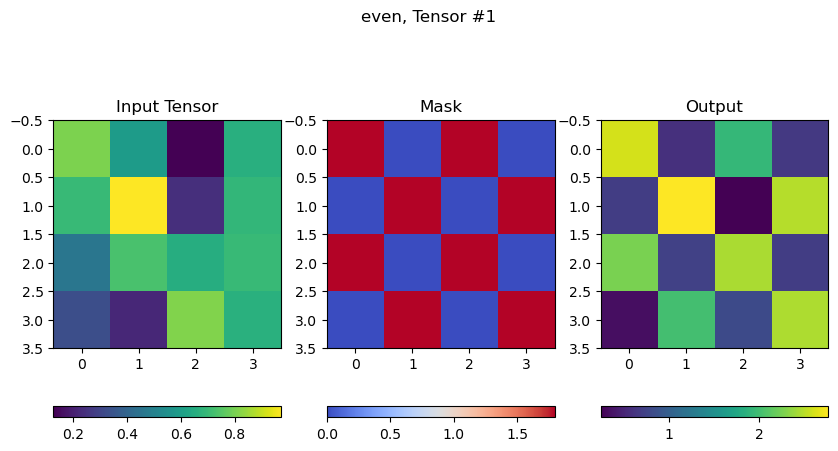

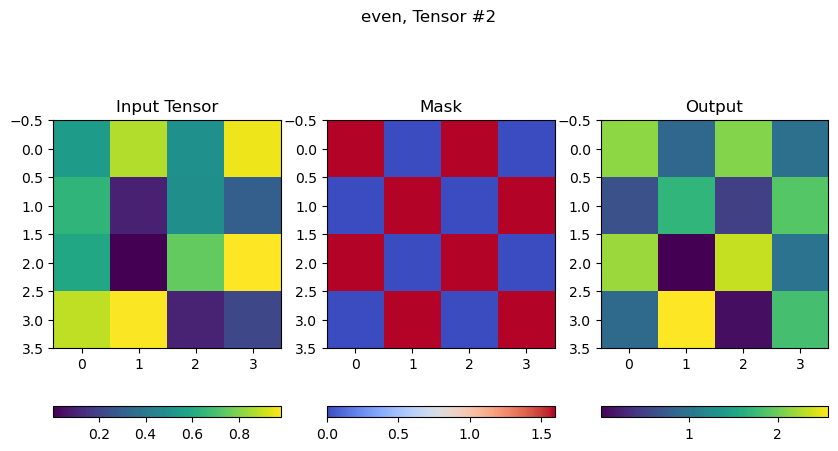

In [67]:
visualize(input_tensor, output_even,"even")

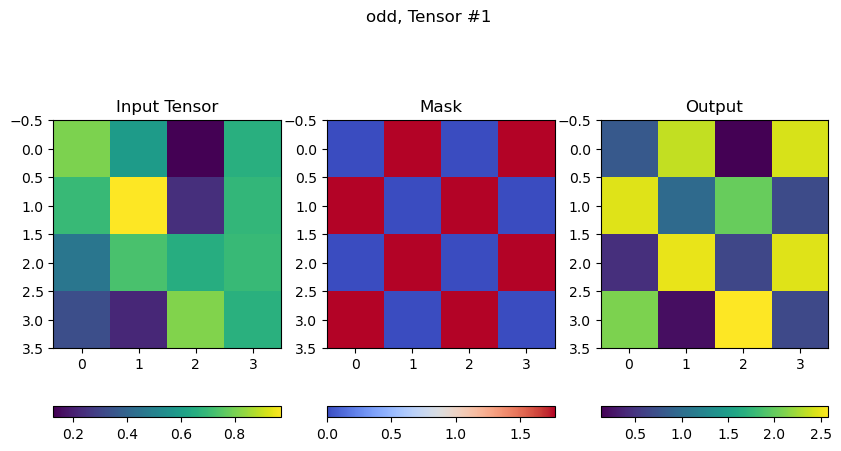

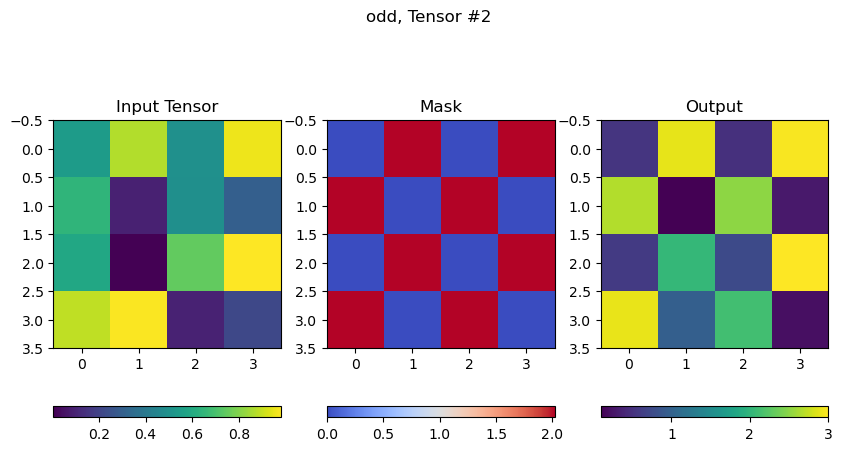

In [68]:
visualize(input_tensor, output_odd,"odd")